In [2]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
EPOCHS = 25
#INIT_LR = 0.01
BS = 100
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'C://Users//acer//Desktop//New Researchers//Kaggle//Tomato//New Plant Diseases Dataset(Augmented)//New Plant Diseases Dataset(Augmented)/'
width=256
height=256
depth=3

In [7]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [8]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___Tomato_mosaic_virus ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___Tomato_mosaic_virus ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Image loading completed


In [9]:
image_size = len(image_list)

In [10]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [11]:
print(label_binarizer.classes_)

['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


In [12]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [13]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [14]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [15]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications import inception_v3
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [16]:
base_model= inception_v3.InceptionV3(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
#we add dense layers so that the model can learn more complex functions and classify for better results.

x = Dense(1024, activation='relu')(x)

preds=Dense(n_classes,activation='softmax')(x) #final layer with softmax activation



87916544/87910968 [==============================] - 442s 5us/step


In [17]:
model=Model(inputs=base_model.input,outputs=preds)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [19]:
for layer in model.layers[:249]:
    layer.trainable=False
for layer in model.layers[249:]:
    layer.trainable=True

In [20]:
# distribution
model.compile(loss="categorical_crossentropy", optimizer='Adam',metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [21]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )


Epoch 1/25
27/27 [==============================] - 514s 19s/step - loss: 0.9089 - accuracy: 0.7074 - val_loss: 23.3254 - val_accuracy: 0.1809
Epoch 2/25
27/27 [==============================] - 522s 19s/step - loss: 0.2659 - accuracy: 0.9126 - val_loss: 19.4541 - val_accuracy: 0.2603
Epoch 3/25
27/27 [==============================] - 529s 20s/step - loss: 0.1954 - accuracy: 0.9313 - val_loss: 5.7494 - val_accuracy: 0.4794
Epoch 4/25
27/27 [==============================] - 521s 19s/step - loss: 0.1152 - accuracy: 0.9630 - val_loss: 4.2757 - val_accuracy: 0.4441
Epoch 5/25
27/27 [==============================] - 702s 26s/step - loss: 0.1260 - accuracy: 0.9603 - val_loss: 4.6103 - val_accuracy: 0.3691
Epoch 6/25
27/27 [==============================] - 821s 30s/step - loss: 0.1396 - accuracy: 0.9576 - val_loss: 3.2874 - val_accuracy: 0.5397
Epoch 7/25
27/27 [==============================] - 900s 33s/step - loss: 0.1215 - accuracy: 0.9656 - val_loss: 3.1133 - val_accuracy: 0.5471
Epo

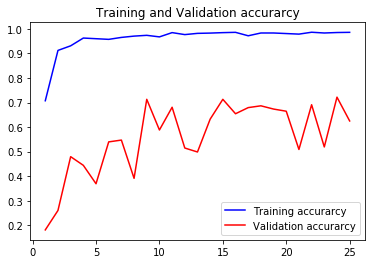

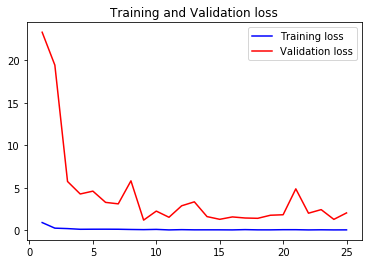

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [25]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
680/680 [==============================] - 163s 239ms/step
Test Accuracy: 62.5
